# The Street View House Numbers (SVHN) Dataset

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. The dataset and more information can be founded [`here`](http://ufldl.stanford.edu/housenumbers/).

## Loading libraries

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from __future__ import print_function
from urllib import urlretrieve
from scipy.io import loadmat
from skimage.transform import resize
from sklearn.model_selection import StratifiedShuffleSplit

## Setting up helper functions

In [2]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [6]:
def equalization(labels, size=1000):
    idx = None
    for i in np.unique(labels):
        draw_bucket, _ = np.where(labels == i)
        samples = np.random.choice(draw_bucket, size=int(size / len(np.unique(labels))))
        if idx is None:
            idx = samples
        else:
            idx = np.concatenate((idx, samples))
    np.random.shuffle(idx)
    return list(idx)

In [9]:
def display_sample_images(features, labels, n, test_data=None, normalized=False):
    """
    Displays a set of images from the dataset.
    
    Args:
    ====
    features: array of images.
    labels: array of the feature's labels.
    n: int, number of images to display.
    normalized: boolean, if True adjusts the function to work with the transformed data.
    """

    fig = plt.figure(figsize=(16, 16))
    for i in range(n):
        plt.subplot(1,n,i + 1)
        image_num = np.random.randint(0, high=len(labels))
        if test_data is not None:
            image_num = test_data
        if normalized:
            image_num = np.random.randint(0, high=10)
            sample_image = np.squeeze(features[image_num], axis=2)
        else:
            sample_image = features[:,:,:,image_num]
        sample_label = labels[image_num]
        
        plt.axis('off')
        plt.title('Label: {}\nFormat: {}\nMin: {:.2f} | Max: {:.2f}'.format(
            sample_label,
            sample_image.shape,
            sample_image.min(),
            sample_image.max()))

        plt.imshow(sample_image)
    plt.show()

In [11]:
def resize_images(features, new_size=(224,224)):
    n = features.shape[3]
    resized_images = []
    for i in range(n):
        image = features[:,:,:,i]
        image = resize(image, new_size)
        resized_images.append(image)
    return resized_images

In [20]:
def one_hot_encode(labels):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    
    Args:
    ====
    labels: List of sample labels
    
    Return:
    =======
    array of one-hot encoded labels
    """
    result = []
    for i in range(len(labels)):
        result.append([1 if labels[i] == j + 1 else 0 for j in range(10)])
    return np.array(result)

In [12]:
def batch_creator(features, labels, batch_size, val_size=None, flatted=False):
    if flatted:
        for start in range(0, len(features), batch_size):
            end = min(start + batch_size, len(features))
            if val_size is not None:
                feat_batch_train, \
                feat_batch_val,\
                lab_batch_train, \
                lab_batch_val = train_test_split(features[start:end,:], labels[start:end], test_size=val_size)
            
                yield feat_batch_train, feat_batch_val, lab_batch_train, lab_batch_val
            else:
                yield features[start:end,:], labels[start:end]
    else:
        for start in range(0, features.shape[3], batch_size):
            end = min(start + batch_size, features.shape[3])
            if val_size is not None:
                feat_batch_train, \
                feat_batch_val,\
                lab_batch_train, \
                lab_batch_val = train_test_split(features[:,:,:,start:end],
                    labels[start:end],
                    test_size=val_size)
            
                yield feat_batch_train, feat_batch_val, lab_batch_train, lab_batch_val
            else:
                yield features[:,:,:,start:end], labels[start:end]

## Loading and understanding the raw data

In [3]:
if not os.path.isfile('../data/train_32x32.mat'):
    if not os.path.isdir('../data'):
        os.mkdir('../data')
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Dataset') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            '../data/train_32x32.mat',
            pbar.hook)

svhn_data = loadmat('../data/train_32x32.mat')
print('Data loaded!')

Data loaded!


In [4]:
print('Data info: ', svhn_data.keys())
print('Features shape: ', svhn_data['X'].shape)
print('Labels shape: ', svhn_data['y'].shape)

Data info:  ['y', 'X', '__version__', '__header__', '__globals__']
Features shape:  (32, 32, 3, 73257)
Labels shape:  (73257, 1)


In [5]:
features = svhn_data['X']
labels = svhn_data['y']
print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))

Label Counts: {1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 9: 4659, 10: 4948}


In [ ]:
display_sample_images(features, labels, 4)

## Reducing and equalizing data

In [7]:
eq_idx = equalization(labels, 10000)

In [8]:
red_features = features[:,:,:,eq_idx]
red_labels = labels[eq_idx]

print('Features: ', red_features.shape)
print('Labels: ', red_labels.shape)
print('Label Counts: {}'.format(dict(zip(*np.unique(red_labels, return_counts=True)))))

Features:  (32, 32, 3, 3000)
Labels:  (3000, 1)
Label Counts: {1: 300, 2: 300, 3: 300, 4: 300, 5: 300, 6: 300, 7: 300, 8: 300, 9: 300, 10: 300}


## Preprocessing features with pre trained VGG16

In [15]:
try:
    from tensorflow_vvg import vgg16
except:
    !git clone https://github.com/machrisaa/tensorflow-vgg.git tensorflow_vgg
    from tensorflow_vgg import vgg16

with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
    urlretrieve(
        'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
        './tensorflow_vgg/vgg16.npy',
        pbar.hook)

Cloning into 'tensorflow_vgg'...
remote: Counting objects: 109, done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (109/109), 56.61 KiB | 0 bytes/s, done.
Resolving deltas: 100% (58/58), done.


VGG16 Parameters: 553MB [05:24, 1.71MB/s]                               


In [18]:
if not os.path.isfile('./code_data.pkl'):
    batch_size = 10
    iteration = 0
    codes = None
    with tf.Session() as sess:
        vgg = vgg16.Vgg16()
        images = tf.placeholder(tf.float32, [None, 224, 224, 3])
        with tf.name_scope('content_vgg'):
            vgg.build(images)
    
        for batch, _ in batch_creator(red_features, red_labels, batch_size):
            print('Processing batch #{:3d}'.format(iteration))
            resized_images = resize_images(batch)
            feed_dict = {images: resized_images}
            codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
            if codes is None:
                codes = codes_batch
            else:
                codes = np.concatenate((codes, codes_batch))
            iteration += 1
        
    with open('./code_data.pkl', 'wb') as f:
        pickle.dump(codes, f)
else:
    with open('./code_data.pkl', 'rb') as f:
        codes = pickle.load(f)

/Users/danielcmresende/Documents/machine-learning/mlnd_capstone/project/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 1s
Processing batch #  0


/Users/danielcmresende/miniconda3/envs/mlcap/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Processing batch #  1
Processing batch #  2
Processing batch #  3
Processing batch #  4
Processing batch #  5
Processing batch #  6
Processing batch #  7
Processing batch #  8
Processing batch #  9
Processing batch # 10
Processing batch # 11
Processing batch # 12
Processing batch # 13
Processing batch # 14
Processing batch # 15
Processing batch # 16
Processing batch # 17
Processing batch # 18
Processing batch # 19
Processing batch # 20
Processing batch # 21
Processing batch # 22
Processing batch # 23
Processing batch # 24
Processing batch # 25
Processing batch # 26
Processing batch # 27
Processing batch # 28
Processing batch # 29
Processing batch # 30
Processing batch # 31
Processing batch # 32
Processing batch # 33
Processing batch # 34
Processing batch # 35
Processing batch # 36
Processing batch # 37
Processing batch # 38
Processing batch # 39
Processing batch # 40
Processing batch # 41
Processing batch # 42
Processing batch # 43
Processing batch # 44
Processing batch # 45
Processing

In [19]:
print(codes.shape)

(3000, 4096)


## One hot enconding the labels

In [21]:
one_hot_labels = one_hot_encode(red_labels)
print(one_hot_labels.shape)

(3000, 10)


## Splitting the data for final training

In [22]:
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

train_idx, val_idx = next(ss.split(codes, one_hot_labels))

half_val_len = int(len(val_idx) / 2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]

train_x, train_y = codes[train_idx], one_hot_labels[train_idx]
val_x, val_y = codes[val_idx], one_hot_labels[val_idx]
test_x, test_y = codes[test_idx], one_hot_labels[test_idx]

In [23]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (2400, 4096) (2400, 10)
Validation shapes (x, y): (300, 4096) (300, 10)
Test shapes (x, y): (300, 4096) (300, 10)


## Building the fully connected layers

In [24]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, one_hot_labels.shape[1]])
keep_prob = tf.placeholder(tf.float32)

relu7 = tf.layers.dense(inputs_, codes.shape[1], activation=tf.nn.relu)
drop7 = tf.nn.dropout(relu7, keep_prob)

logits = tf.layers.dense(drop7, one_hot_labels.shape[1])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))

optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Training

In [30]:
epochs = 10
batch_size = 10
iteration = 0

saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in batch_creator(train_x, train_y, batch_size=batch_size, flatted=True):
            feed = {inputs_: x,
                    labels_: y,
                    keep_prob: 0.5
                   }
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e, epochs - 1),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            
            if iteration % 50 == 0 or iteration == (train_x.shape[0] - 1):
                feed = {inputs_: val_x,
                        labels_: val_y,
                        keep_prob: 1.0
                       }
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("***\nEpoch: {}/{}".format(e, epochs - 1),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}\n***".format(val_acc))
            
            iteration += 1
            
    saver.save(sess, "checkpoints/svhn.ckpt")

Epoch: 0/9 Iteration: 0 Training loss: 4.74416
***
Epoch: 0/9 Iteration: 0 Validation Acc: 0.1000
***
Epoch: 0/9 Iteration: 1 Training loss: 42.24430
Epoch: 0/9 Iteration: 2 Training loss: 14.49187
Epoch: 0/9 Iteration: 3 Training loss: 23.70087
Epoch: 0/9 Iteration: 4 Training loss: 39.47435
Epoch: 0/9 Iteration: 5 Training loss: 31.80557
Epoch: 0/9 Iteration: 6 Training loss: 33.72009
Epoch: 0/9 Iteration: 7 Training loss: 16.81004
Epoch: 0/9 Iteration: 8 Training loss: 33.75824
Epoch: 0/9 Iteration: 9 Training loss: 35.99119
Epoch: 0/9 Iteration: 10 Training loss: 22.00358
Epoch: 0/9 Iteration: 11 Training loss: 26.90046
Epoch: 0/9 Iteration: 12 Training loss: 35.94595
Epoch: 0/9 Iteration: 13 Training loss: 19.28878
Epoch: 0/9 Iteration: 14 Training loss: 27.83956
Epoch: 0/9 Iteration: 15 Training loss: 19.00770
Epoch: 0/9 Iteration: 16 Training loss: 32.42262
Epoch: 0/9 Iteration: 17 Training loss: 35.67191
Epoch: 0/9 Iteration: 18 Training loss: 27.82884
Epoch: 0/9 Iteration: 19 

Epoch: 0/9 Iteration: 164 Training loss: 2.25657
Epoch: 0/9 Iteration: 165 Training loss: 1.70601
Epoch: 0/9 Iteration: 166 Training loss: 2.15330
Epoch: 0/9 Iteration: 167 Training loss: 1.42998
Epoch: 0/9 Iteration: 168 Training loss: 1.57300
Epoch: 0/9 Iteration: 169 Training loss: 1.67423
Epoch: 0/9 Iteration: 170 Training loss: 0.68469
Epoch: 0/9 Iteration: 171 Training loss: 1.43719
Epoch: 0/9 Iteration: 172 Training loss: 1.89705
Epoch: 0/9 Iteration: 173 Training loss: 1.89079
Epoch: 0/9 Iteration: 174 Training loss: 1.92152
Epoch: 0/9 Iteration: 175 Training loss: 1.29521
Epoch: 0/9 Iteration: 176 Training loss: 1.89476
Epoch: 0/9 Iteration: 177 Training loss: 2.12278
Epoch: 0/9 Iteration: 178 Training loss: 1.32889
Epoch: 0/9 Iteration: 179 Training loss: 1.75346
Epoch: 0/9 Iteration: 180 Training loss: 0.74003
Epoch: 0/9 Iteration: 181 Training loss: 1.35781
Epoch: 0/9 Iteration: 182 Training loss: 0.94869
Epoch: 0/9 Iteration: 183 Training loss: 1.49411
Epoch: 0/9 Iteration

Epoch: 1/9 Iteration: 329 Training loss: 2.10303
Epoch: 1/9 Iteration: 330 Training loss: 2.61105
Epoch: 1/9 Iteration: 331 Training loss: 1.54667
Epoch: 1/9 Iteration: 332 Training loss: 1.20160
Epoch: 1/9 Iteration: 333 Training loss: 1.27831
Epoch: 1/9 Iteration: 334 Training loss: 1.66397
Epoch: 1/9 Iteration: 335 Training loss: 1.25366
Epoch: 1/9 Iteration: 336 Training loss: 2.01529
Epoch: 1/9 Iteration: 337 Training loss: 1.49857
Epoch: 1/9 Iteration: 338 Training loss: 1.34679
Epoch: 1/9 Iteration: 339 Training loss: 0.68515
Epoch: 1/9 Iteration: 340 Training loss: 1.79984
Epoch: 1/9 Iteration: 341 Training loss: 1.69971
Epoch: 1/9 Iteration: 342 Training loss: 1.38147
Epoch: 1/9 Iteration: 343 Training loss: 1.16451
Epoch: 1/9 Iteration: 344 Training loss: 1.15842
Epoch: 1/9 Iteration: 345 Training loss: 1.25213
Epoch: 1/9 Iteration: 346 Training loss: 1.01179
Epoch: 1/9 Iteration: 347 Training loss: 1.36956
Epoch: 1/9 Iteration: 348 Training loss: 0.99499
Epoch: 1/9 Iteration

Epoch: 2/9 Iteration: 494 Training loss: 1.11105
Epoch: 2/9 Iteration: 495 Training loss: 1.09879
Epoch: 2/9 Iteration: 496 Training loss: 1.53493
Epoch: 2/9 Iteration: 497 Training loss: 0.76765
Epoch: 2/9 Iteration: 498 Training loss: 1.85475
Epoch: 2/9 Iteration: 499 Training loss: 1.69683
Epoch: 2/9 Iteration: 500 Training loss: 1.64406
***
Epoch: 2/9 Iteration: 500 Validation Acc: 0.6733
***
Epoch: 2/9 Iteration: 501 Training loss: 0.74573
Epoch: 2/9 Iteration: 502 Training loss: 0.75753
Epoch: 2/9 Iteration: 503 Training loss: 1.84229
Epoch: 2/9 Iteration: 504 Training loss: 1.51675
Epoch: 2/9 Iteration: 505 Training loss: 1.53085
Epoch: 2/9 Iteration: 506 Training loss: 1.72973
Epoch: 2/9 Iteration: 507 Training loss: 1.21857
Epoch: 2/9 Iteration: 508 Training loss: 1.56267
Epoch: 2/9 Iteration: 509 Training loss: 2.43501
Epoch: 2/9 Iteration: 510 Training loss: 1.20187
Epoch: 2/9 Iteration: 511 Training loss: 1.89758
Epoch: 2/9 Iteration: 512 Training loss: 1.11762
Epoch: 2/9 I

Epoch: 2/9 Iteration: 658 Training loss: 1.03277
Epoch: 2/9 Iteration: 659 Training loss: 1.02371
Epoch: 2/9 Iteration: 660 Training loss: 0.55228
Epoch: 2/9 Iteration: 661 Training loss: 1.34364
Epoch: 2/9 Iteration: 662 Training loss: 1.02586
Epoch: 2/9 Iteration: 663 Training loss: 0.69001
Epoch: 2/9 Iteration: 664 Training loss: 1.83938
Epoch: 2/9 Iteration: 665 Training loss: 1.91208
Epoch: 2/9 Iteration: 666 Training loss: 1.43113
Epoch: 2/9 Iteration: 667 Training loss: 1.22613
Epoch: 2/9 Iteration: 668 Training loss: 1.08525
Epoch: 2/9 Iteration: 669 Training loss: 1.30232
Epoch: 2/9 Iteration: 670 Training loss: 1.08722
Epoch: 2/9 Iteration: 671 Training loss: 1.20350
Epoch: 2/9 Iteration: 672 Training loss: 1.09508
Epoch: 2/9 Iteration: 673 Training loss: 1.54659
Epoch: 2/9 Iteration: 674 Training loss: 1.11371
Epoch: 2/9 Iteration: 675 Training loss: 0.89652
Epoch: 2/9 Iteration: 676 Training loss: 1.38489
Epoch: 2/9 Iteration: 677 Training loss: 1.27586
Epoch: 2/9 Iteration

Epoch: 3/9 Iteration: 822 Training loss: 1.03492
Epoch: 3/9 Iteration: 823 Training loss: 1.08112
Epoch: 3/9 Iteration: 824 Training loss: 0.73193
Epoch: 3/9 Iteration: 825 Training loss: 0.77845
Epoch: 3/9 Iteration: 826 Training loss: 1.05020
Epoch: 3/9 Iteration: 827 Training loss: 1.89561
Epoch: 3/9 Iteration: 828 Training loss: 1.05941
Epoch: 3/9 Iteration: 829 Training loss: 1.22055
Epoch: 3/9 Iteration: 830 Training loss: 0.82084
Epoch: 3/9 Iteration: 831 Training loss: 1.30791
Epoch: 3/9 Iteration: 832 Training loss: 1.21542
Epoch: 3/9 Iteration: 833 Training loss: 0.70867
Epoch: 3/9 Iteration: 834 Training loss: 0.75424
Epoch: 3/9 Iteration: 835 Training loss: 0.57669
Epoch: 3/9 Iteration: 836 Training loss: 0.61684
Epoch: 3/9 Iteration: 837 Training loss: 0.72056
Epoch: 3/9 Iteration: 838 Training loss: 1.56714
Epoch: 3/9 Iteration: 839 Training loss: 1.58095
Epoch: 3/9 Iteration: 840 Training loss: 1.11111
Epoch: 3/9 Iteration: 841 Training loss: 1.17328
Epoch: 3/9 Iteration

Epoch: 4/9 Iteration: 987 Training loss: 1.49344
Epoch: 4/9 Iteration: 988 Training loss: 1.61061
Epoch: 4/9 Iteration: 989 Training loss: 1.16575
Epoch: 4/9 Iteration: 990 Training loss: 1.42832
Epoch: 4/9 Iteration: 991 Training loss: 0.72896
Epoch: 4/9 Iteration: 992 Training loss: 1.12483
Epoch: 4/9 Iteration: 993 Training loss: 0.46686
Epoch: 4/9 Iteration: 994 Training loss: 1.08646
Epoch: 4/9 Iteration: 995 Training loss: 0.85131
Epoch: 4/9 Iteration: 996 Training loss: 1.13507
Epoch: 4/9 Iteration: 997 Training loss: 0.67506
Epoch: 4/9 Iteration: 998 Training loss: 1.58367
Epoch: 4/9 Iteration: 999 Training loss: 1.06711
Epoch: 4/9 Iteration: 1000 Training loss: 1.38699
***
Epoch: 4/9 Iteration: 1000 Validation Acc: 0.6500
***
Epoch: 4/9 Iteration: 1001 Training loss: 1.18226
Epoch: 4/9 Iteration: 1002 Training loss: 1.52994
Epoch: 4/9 Iteration: 1003 Training loss: 1.65823
Epoch: 4/9 Iteration: 1004 Training loss: 0.76066
Epoch: 4/9 Iteration: 1005 Training loss: 1.26503
Epoch

Epoch: 4/9 Iteration: 1148 Training loss: 1.22525
Epoch: 4/9 Iteration: 1149 Training loss: 1.32644
Epoch: 4/9 Iteration: 1150 Training loss: 0.53302
***
Epoch: 4/9 Iteration: 1150 Validation Acc: 0.6400
***
Epoch: 4/9 Iteration: 1151 Training loss: 0.88962
Epoch: 4/9 Iteration: 1152 Training loss: 0.98794
Epoch: 4/9 Iteration: 1153 Training loss: 1.32487
Epoch: 4/9 Iteration: 1154 Training loss: 1.56813
Epoch: 4/9 Iteration: 1155 Training loss: 1.64239
Epoch: 4/9 Iteration: 1156 Training loss: 0.86047
Epoch: 4/9 Iteration: 1157 Training loss: 0.80646
Epoch: 4/9 Iteration: 1158 Training loss: 0.92258
Epoch: 4/9 Iteration: 1159 Training loss: 0.55679
Epoch: 4/9 Iteration: 1160 Training loss: 1.30920
Epoch: 4/9 Iteration: 1161 Training loss: 1.24741
Epoch: 4/9 Iteration: 1162 Training loss: 2.07951
Epoch: 4/9 Iteration: 1163 Training loss: 1.07563
Epoch: 4/9 Iteration: 1164 Training loss: 1.47857
Epoch: 4/9 Iteration: 1165 Training loss: 1.11878
Epoch: 4/9 Iteration: 1166 Training loss: 

Epoch: 5/9 Iteration: 1308 Training loss: 0.68754
Epoch: 5/9 Iteration: 1309 Training loss: 0.99356
Epoch: 5/9 Iteration: 1310 Training loss: 0.61431
Epoch: 5/9 Iteration: 1311 Training loss: 0.85667
Epoch: 5/9 Iteration: 1312 Training loss: 1.20909
Epoch: 5/9 Iteration: 1313 Training loss: 1.65187
Epoch: 5/9 Iteration: 1314 Training loss: 1.09766
Epoch: 5/9 Iteration: 1315 Training loss: 0.91389
Epoch: 5/9 Iteration: 1316 Training loss: 0.86000
Epoch: 5/9 Iteration: 1317 Training loss: 0.77069
Epoch: 5/9 Iteration: 1318 Training loss: 1.21302
Epoch: 5/9 Iteration: 1319 Training loss: 1.32044
Epoch: 5/9 Iteration: 1320 Training loss: 0.48661
Epoch: 5/9 Iteration: 1321 Training loss: 1.24106
Epoch: 5/9 Iteration: 1322 Training loss: 0.66154
Epoch: 5/9 Iteration: 1323 Training loss: 0.62244
Epoch: 5/9 Iteration: 1324 Training loss: 1.16134
Epoch: 5/9 Iteration: 1325 Training loss: 1.46212
Epoch: 5/9 Iteration: 1326 Training loss: 1.04012
Epoch: 5/9 Iteration: 1327 Training loss: 1.57785


Epoch: 6/9 Iteration: 1470 Training loss: 0.96308
Epoch: 6/9 Iteration: 1471 Training loss: 0.98007
Epoch: 6/9 Iteration: 1472 Training loss: 1.13795
Epoch: 6/9 Iteration: 1473 Training loss: 0.62020
Epoch: 6/9 Iteration: 1474 Training loss: 1.07188
Epoch: 6/9 Iteration: 1475 Training loss: 1.47474
Epoch: 6/9 Iteration: 1476 Training loss: 0.77979
Epoch: 6/9 Iteration: 1477 Training loss: 1.02251
Epoch: 6/9 Iteration: 1478 Training loss: 1.20012
Epoch: 6/9 Iteration: 1479 Training loss: 0.57808
Epoch: 6/9 Iteration: 1480 Training loss: 1.53513
Epoch: 6/9 Iteration: 1481 Training loss: 0.71409
Epoch: 6/9 Iteration: 1482 Training loss: 0.90721
Epoch: 6/9 Iteration: 1483 Training loss: 1.39708
Epoch: 6/9 Iteration: 1484 Training loss: 0.93482
Epoch: 6/9 Iteration: 1485 Training loss: 1.17775
Epoch: 6/9 Iteration: 1486 Training loss: 0.80180
Epoch: 6/9 Iteration: 1487 Training loss: 1.12205
Epoch: 6/9 Iteration: 1488 Training loss: 0.46571
Epoch: 6/9 Iteration: 1489 Training loss: 0.67156


Epoch: 6/9 Iteration: 1632 Training loss: 0.67933
Epoch: 6/9 Iteration: 1633 Training loss: 0.88349
Epoch: 6/9 Iteration: 1634 Training loss: 1.14237
Epoch: 6/9 Iteration: 1635 Training loss: 1.35627
Epoch: 6/9 Iteration: 1636 Training loss: 1.68715
Epoch: 6/9 Iteration: 1637 Training loss: 0.85792
Epoch: 6/9 Iteration: 1638 Training loss: 0.63887
Epoch: 6/9 Iteration: 1639 Training loss: 0.70394
Epoch: 6/9 Iteration: 1640 Training loss: 1.28119
Epoch: 6/9 Iteration: 1641 Training loss: 1.09602
Epoch: 6/9 Iteration: 1642 Training loss: 1.69469
Epoch: 6/9 Iteration: 1643 Training loss: 0.90107
Epoch: 6/9 Iteration: 1644 Training loss: 1.68536
Epoch: 6/9 Iteration: 1645 Training loss: 1.83995
Epoch: 6/9 Iteration: 1646 Training loss: 0.74563
Epoch: 6/9 Iteration: 1647 Training loss: 0.76344
Epoch: 6/9 Iteration: 1648 Training loss: 1.16938
Epoch: 6/9 Iteration: 1649 Training loss: 0.62482
Epoch: 6/9 Iteration: 1650 Training loss: 1.18080
***
Epoch: 6/9 Iteration: 1650 Validation Acc: 0.7

Epoch: 7/9 Iteration: 1794 Training loss: 0.90617
Epoch: 7/9 Iteration: 1795 Training loss: 0.96672
Epoch: 7/9 Iteration: 1796 Training loss: 1.01377
Epoch: 7/9 Iteration: 1797 Training loss: 1.00290
Epoch: 7/9 Iteration: 1798 Training loss: 0.99580
Epoch: 7/9 Iteration: 1799 Training loss: 1.53366
Epoch: 7/9 Iteration: 1800 Training loss: 0.50145
***
Epoch: 7/9 Iteration: 1800 Validation Acc: 0.7033
***
Epoch: 7/9 Iteration: 1801 Training loss: 1.09553
Epoch: 7/9 Iteration: 1802 Training loss: 0.57660
Epoch: 7/9 Iteration: 1803 Training loss: 0.35727
Epoch: 7/9 Iteration: 1804 Training loss: 1.12583
Epoch: 7/9 Iteration: 1805 Training loss: 1.48886
Epoch: 7/9 Iteration: 1806 Training loss: 0.77460
Epoch: 7/9 Iteration: 1807 Training loss: 0.74866
Epoch: 7/9 Iteration: 1808 Training loss: 0.77306
Epoch: 7/9 Iteration: 1809 Training loss: 0.79051
Epoch: 7/9 Iteration: 1810 Training loss: 1.24002
Epoch: 7/9 Iteration: 1811 Training loss: 0.99443
Epoch: 7/9 Iteration: 1812 Training loss: 

Epoch: 8/9 Iteration: 1954 Training loss: 1.41694
Epoch: 8/9 Iteration: 1955 Training loss: 1.91884
Epoch: 8/9 Iteration: 1956 Training loss: 1.01031
Epoch: 8/9 Iteration: 1957 Training loss: 0.84703
Epoch: 8/9 Iteration: 1958 Training loss: 0.50242
Epoch: 8/9 Iteration: 1959 Training loss: 1.27591
Epoch: 8/9 Iteration: 1960 Training loss: 0.99921
Epoch: 8/9 Iteration: 1961 Training loss: 0.73406
Epoch: 8/9 Iteration: 1962 Training loss: 1.05228
Epoch: 8/9 Iteration: 1963 Training loss: 1.65015
Epoch: 8/9 Iteration: 1964 Training loss: 1.13223
Epoch: 8/9 Iteration: 1965 Training loss: 1.00675
Epoch: 8/9 Iteration: 1966 Training loss: 0.59819
Epoch: 8/9 Iteration: 1967 Training loss: 1.61781
Epoch: 8/9 Iteration: 1968 Training loss: 0.72540
Epoch: 8/9 Iteration: 1969 Training loss: 1.15312
Epoch: 8/9 Iteration: 1970 Training loss: 2.12054
Epoch: 8/9 Iteration: 1971 Training loss: 1.70951
Epoch: 8/9 Iteration: 1972 Training loss: 0.98468
Epoch: 8/9 Iteration: 1973 Training loss: 0.67556


Epoch: 8/9 Iteration: 2116 Training loss: 1.25287
Epoch: 8/9 Iteration: 2117 Training loss: 0.63947
Epoch: 8/9 Iteration: 2118 Training loss: 0.80807
Epoch: 8/9 Iteration: 2119 Training loss: 0.56644
Epoch: 8/9 Iteration: 2120 Training loss: 1.31642
Epoch: 8/9 Iteration: 2121 Training loss: 1.06178
Epoch: 8/9 Iteration: 2122 Training loss: 1.36017
Epoch: 8/9 Iteration: 2123 Training loss: 0.83446
Epoch: 8/9 Iteration: 2124 Training loss: 1.45874
Epoch: 8/9 Iteration: 2125 Training loss: 1.18141
Epoch: 8/9 Iteration: 2126 Training loss: 0.77410
Epoch: 8/9 Iteration: 2127 Training loss: 1.84368
Epoch: 8/9 Iteration: 2128 Training loss: 1.01716
Epoch: 8/9 Iteration: 2129 Training loss: 0.55789
Epoch: 8/9 Iteration: 2130 Training loss: 1.42384
Epoch: 8/9 Iteration: 2131 Training loss: 0.89586
Epoch: 8/9 Iteration: 2132 Training loss: 2.10923
Epoch: 8/9 Iteration: 2133 Training loss: 1.69345
Epoch: 8/9 Iteration: 2134 Training loss: 1.37196
Epoch: 8/9 Iteration: 2135 Training loss: 1.23714


Epoch: 9/9 Iteration: 2278 Training loss: 0.76065
Epoch: 9/9 Iteration: 2279 Training loss: 1.18770
Epoch: 9/9 Iteration: 2280 Training loss: 0.47276
Epoch: 9/9 Iteration: 2281 Training loss: 1.53274
Epoch: 9/9 Iteration: 2282 Training loss: 1.10833
Epoch: 9/9 Iteration: 2283 Training loss: 0.77132
Epoch: 9/9 Iteration: 2284 Training loss: 1.05647
Epoch: 9/9 Iteration: 2285 Training loss: 1.89725
Epoch: 9/9 Iteration: 2286 Training loss: 0.77870
Epoch: 9/9 Iteration: 2287 Training loss: 1.20205
Epoch: 9/9 Iteration: 2288 Training loss: 0.62336
Epoch: 9/9 Iteration: 2289 Training loss: 1.08538
Epoch: 9/9 Iteration: 2290 Training loss: 0.88505
Epoch: 9/9 Iteration: 2291 Training loss: 1.61610
Epoch: 9/9 Iteration: 2292 Training loss: 0.81576
Epoch: 9/9 Iteration: 2293 Training loss: 0.78667
Epoch: 9/9 Iteration: 2294 Training loss: 0.58650
Epoch: 9/9 Iteration: 2295 Training loss: 0.63198
Epoch: 9/9 Iteration: 2296 Training loss: 1.31269
Epoch: 9/9 Iteration: 2297 Training loss: 1.49654


## Testing

In [35]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y,
            keep_prob: 1.0
           }
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:3.2f}%".format(test_acc * 100))

Test accuracy: 68.33%


## Playing with a sample image

In [60]:
sample_image_idx = np.random.randint(0, labels.shape[0])
sample_image = features[:,:,:,sample_image_idx]
sample_label = labels[sample_image_idx]

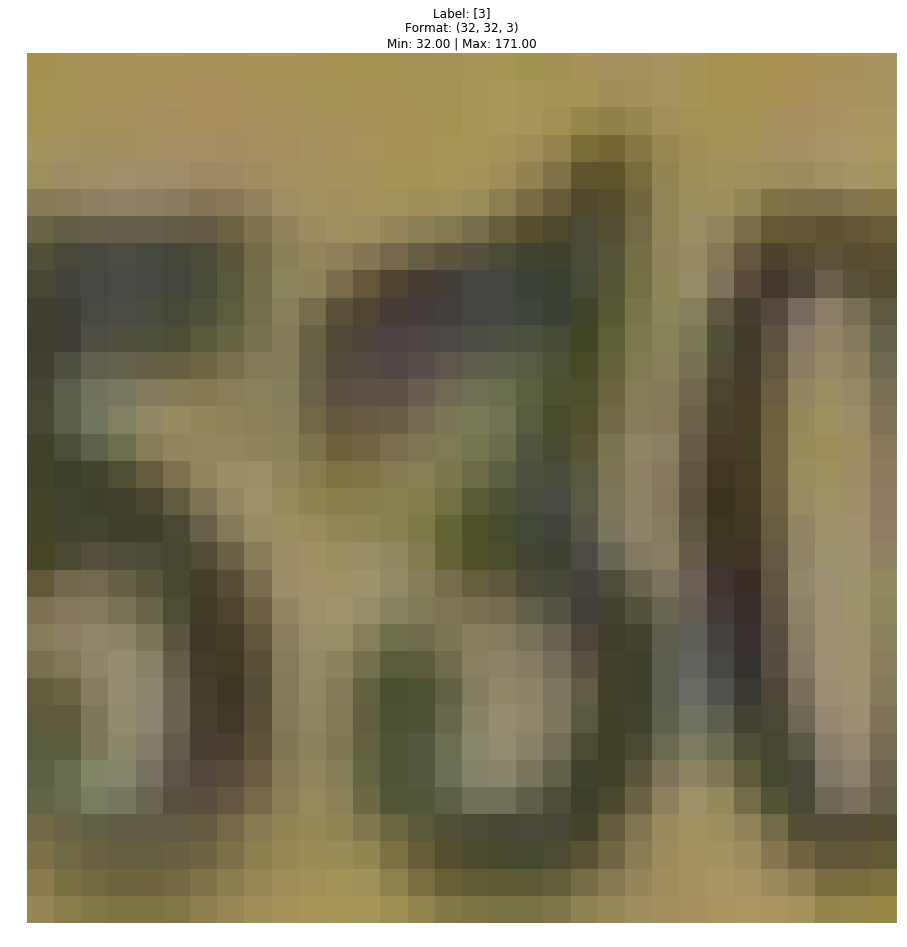

In [61]:
display_sample_images(features, labels, 1, test_data=sample_image_idx)

In [62]:
with tf.Session() as sess:
    resized_image = resize_images(sample_image[:,:,:,np.newaxis])
    feed_dict = {images: resized_image}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code, keep_prob: 1.0}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

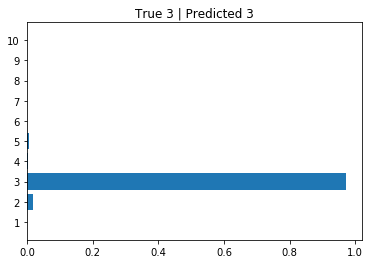

In [64]:
plt.barh(np.arange(10), prediction)
plt.title('True {} | Predicted {}'.format(sample_label[0], np.argmax(prediction) + 1))
plt.yticks(np.arange(10), np.unique(labels))
plt.show()